# Import libraries

In [ ]:
%matplotlib inline

import os
import sys
import shutil
print("Python:", sys.version)

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
print("NumPy version:", np.__version__)

import scipy
from scipy.io import loadmat
print("SciPy version:", scipy.__version__)

import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib version:", matplotlib.__version__)

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("scikit-learn version:", sklearn.__version__)

np.random.seed(99)
tf.random.set_seed(99)

Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
TensorFlow version: 2.18.0
Keras version: 3.8.0
NumPy version: 1.26.4
SciPy version: 1.13.1
Matplotlib version: 3.10.0
scikit-learn version: 1.6.1


# Download and load the SVHN dataset

In [ ]:
TRAIN_DATASET_PATH = "dataset/train_32x32.mat"
TEST_DATASET_PATH = "dataset/test_32x32.mat"

In [ ]:
if not os.path.isdir("dataset"):
    os.makedirs("dataset")

if not os.path.isfile(TRAIN_DATASET_PATH):
    download_location = tf.keras.utils.get_file(origin=r"http://ufldl.stanford.edu/housenumbers/train_32x32.mat")
    shutil.move(download_location, TRAIN_DATASET_PATH)

if not os.path.isfile(TEST_DATASET_PATH):
    download_location = tf.keras.utils.get_file(origin=r"http://ufldl.stanford.edu/housenumbers/test_32x32.mat")
    shutil.move(download_location, TEST_DATASET_PATH)

In [ ]:
train_dataset = loadmat(TRAIN_DATASET_PATH)
X_train = train_dataset["X"]
y_train = train_dataset["y"]
X_train = X_train.astype("float") / 255
X_train = np.moveaxis(X_train, -1, 0)

y_train[np.where(y_train == 10)] = 0
y_train = tf.keras.utils.to_categorical(y_train, 10)

In [ ]:
X_train.shape

(73257, 32, 32, 3)

In [ ]:
y_train.shape

(73257, 10)

In [ ]:
test_dataset = loadmat(TEST_DATASET_PATH)
X_test = test_dataset["X"]
y_test = test_dataset["y"]
X_test = X_test.astype("float") / 255
X_test = np.moveaxis(X_test, -1, 0)

y_test[np.where(y_test == 10)] = 0
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
X_test.shape

(26032, 32, 32, 3)

In [ ]:
y_test.shape

(26032, 10)

# Drop Activation Layer

In [ ]:
# Original Drop Activation from the research paper.
# Sourced and modified from
# https://github.com/LeungSamWai/Drop-Activation/blob/master/models/cifar/da_wrn.py


import tensorflow_probability as tfp

class DropActivation(Layer):
    def __init__(self, keep_prob=0.80, **kwargs):
        '''
        :param keep_prob: the probability of retaining the ReLU activation
        '''
        super(DropActivation, self).__init__()
        self.keep_prob = keep_prob

    def call(self, x, training=None):
        '''
        :param x: input of x
        :return: drop activation during training or testing phase
        '''
        size_len = len(x.shape)
        if training:
            # Bernoulli_mask = torch.cuda.FloatTensor(x.size()[0:size_len]).fill_(1)
            # Bernoulli_mask = tf.ones(x.shape)
            # Bernoulli_mask.bernoulli_(self.keep_prob)
            Bernoulli_distribution = tfp.distributions.Bernoulli(probs=self.keep_prob)
            Bernoulli_sample = Bernoulli_distribution.sample(x.shape[1:])
            Bernoulli_mask = Bernoulli_sample
            Bernoulli_mask = tf.cast(Bernoulli_mask, tf.float32)
            # temp = torch.Tensor().cuda()
            # output = torch.Tensor().cuda()
            # temp.resize_as_(x).copy_(x)
            # output.resize_as_(x).copy_(x)
            temp = tf.identity(x)
            output = tf.identity(x)
            # output.mul_(Bernoulli_mask)
            output = tf.math.multiply(output, Bernoulli_mask)
            # output.mul_(-1)
            output = tf.math.multiply(output, -1)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            # temp.clamp_(min = 0)
            temp = tf.math.maximum(temp, 0)
            # temp.mul_(Bernoulli_mask)
            temp = tf.math.multiply(temp, Bernoulli_mask)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            return output
        else:
            # temp = torch.Tensor().cuda()
            # output = torch.Tensor().cuda()
            # temp.resize_as_(x).copy_(x)
            # output.resize_as_(x).copy_(x)
            temp = tf.identity(x)
            output = tf.identity(x)
            # output.mul_(self.keep_prob)
            output = tf.math.multiply(output, self.keep_prob)
            # output.mul_(-1)
            output = tf.math.multiply(output, -1)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            # temp.clamp_(min=0)
            temp = tf.math.maximum(temp, 0)
            # temp.mul_(self.keep_prob)
            temp = tf.math.multiply(temp, self.keep_prob)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            return output

# Create model

In [ ]:
# AlexNet architecture with Drop Activation.

model = tf.keras.Sequential([
    Input(shape=(32, 32, 3)),

    Conv2D(32, (5, 5), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation="relu", padding="valid"),
    Conv2D(64, (1, 1), activation="relu", padding="valid"),
    Conv2D(128, (1, 1), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256),
    DropActivation(),
    Dense(128),
    DropActivation(),
    Dense(64),
    DropActivation(),
    Dropout(0.5),

    Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 6, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_activation (DropActivation)     │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_activation_1 (DropActivation)   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_activation_2 (DropActivation)   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,042 (843.91 KB)

 Trainable params: 215,914 (843.41 KB)

 Non-trainable params: 128 (512.00 B)

# Train the model

In [ ]:
best_model_saving_callback = ModelCheckpoint(filepath="Best Model.keras", monitor="val_accuracy", mode="max", save_best_only=True)

In [ ]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, callbacks=[best_model_saving_callback])

Epoch 1/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.5506 - loss: 1.3214 - val_accuracy: 0.8486 - val_loss: 0.4962
Epoch 2/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8506 - loss: 0.5182 - val_accuracy: 0.8241 - val_loss: 0.5754
Epoch 3/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8757 - loss: 0.4392 - val_accuracy: 0.8719 - val_loss: 0.4380
Epoch 4/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8881 - loss: 0.3973 - val_accuracy: 0.8900 - val_loss: 0.3735
Epoch 5/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8988 - loss: 0.3594 - val_accuracy: 0.8670 - val_loss: 0.4616
Epoch 6/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9055 - loss: 0.3426 - val_accuracy: 0.8938 - val_loss: 0.3630
Epoch 7/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9125 - loss: 0.3169 - val_accuracy: 0.8876 - val_loss: 0.3908
Epoch 8/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9138 - loss: 0.3

In [ ]:
# Save fully trained model and load the best model for further evaluation cells.
fully_trained_model = model
model = tf.keras.models.load_model("Best Model.keras", custom_objects={"DropActivation": DropActivation})

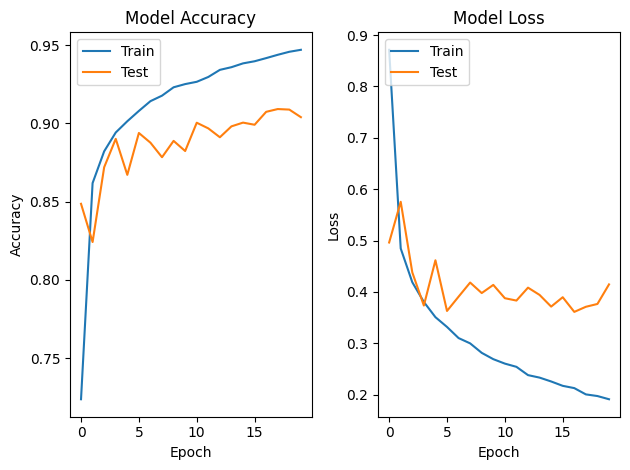

In [ ]:
fig, axis = plt.subplots(1, 2)

axis[0].plot(history.history["accuracy"])
axis[0].plot(history.history["val_accuracy"])
axis[0].set_title("Model Accuracy")
axis[0].set_ylabel("Accuracy")
axis[0].set_xlabel("Epoch")
axis[0].legend(["Train", "Test"], loc="upper left")

# summarize history for loss
axis[1].plot(history.history["loss"])
axis[1].plot(history.history["val_loss"])
axis[1].set_title("Model Loss")
axis[1].set_ylabel("Loss")
axis[1].set_xlabel("Epoch")
axis[1].legend(["Train", "Test"], loc="upper left")

fig.tight_layout()
plt.show()

# Model Accuracy

In [ ]:
d = model.evaluate(X_test, y_test, return_dict=True)
model_accuracy_truncated = int(d["accuracy"] * 100 * 100) / 100
d

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9026 - loss: 0.3975


{'accuracy': 0.9052704572677612, 'loss': 0.39043235778808594}

In [ ]:
y_pred = model.predict(X_test)

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
model.compute_metrics(X_test, y_test, y_pred)

{'accuracy': 0.9052704572677612, 'loss': 0.39043235778808594}

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred.argmax(axis=-1), normalize="true")

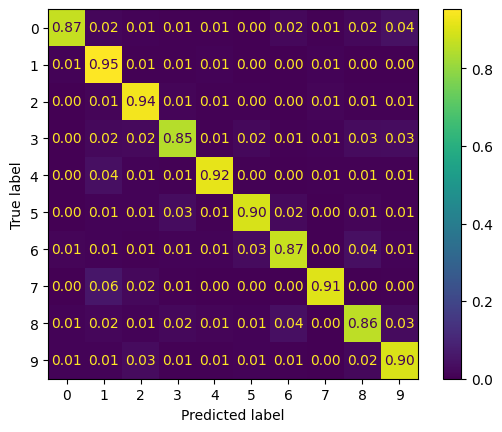

In [ ]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=-1), y_pred.argmax(axis=-1), normalize="true", values_format=".2f")

# Save model

In [ ]:
model.save(f"Colab AlexNet DA {model_accuracy_truncated}.keras")

In [ ]:
# Accuracy over 5 runs.
# 90.52
#
#
#
#
# Average: .

# Load model for inference

In [ ]:
# model = tf.keras.models.load_model("Colab SVHN AlexNet DA.keras", custom_objects={"DropActivation": DropActivation})

In [ ]:
# model.evaluate(X_test, y_test, return_dict=True)